# Experimental Notebook

## Initialize Packages

This notebook is meant as an easy way of setting up experiments using the vacuum chamber and a combination of tools. 

In order to do this, we import the experiments package, which is build on the machines package, specifically build for running the machines connected to the vacuum chamber.

Note: Lucam requires a dll to be downloaded in the form of a driver. https://www.lumenera.com/infinity-analyze-and-capture-for-windows.html

In [ ]:
# Installs a few not entirely common packages needed to run the machines and experiments
!pip install lucam
!pip install pyvisa
!pip install plotly
!pip install pandas

In [1]:
# Import the experiments package
%matplotlib notebook
from experiments import *
import numpy as np

Five different kinds of experiments are available.

1. Amperemeter ( Varying wire grid position )
2. Power supply - Constant ( Varying wire grid position )
3. Power supply - Variable ( Varying wire grid and voltage on one channel )
4. Threshold extractino voltage ( Varying wire grid and voltage on one channel, slightly different from 3. )
5. Current Monitor ( Live graph of current at phosphor screen for terahertz optimization )

Numbers two and three an be run with the lucam camera. Note: Camera can cause measurement to crash due to momentary laps in connection.

We will now go through setting up each type of experiment, starting from the top.



## 1. Amperemeter

Common for all three experiments is that they need wire grid positions. The electrical field scales by the wire grid angle as: $E/E_0 = cos^2(\theta)$

Often you want to select the angle from the electric field using the following equation, where theta is isolated: $\theta=arccos(\sqrt{E/E_0})$

Now selecting 6 positions ranging from 100% electric field to 40%.

In [1]:
from experiments import *
import numpy as np
positions =  [90] + [np.arccos(np.sqrt(E)) * 180 / np.pi for E in np.linspace(0.40,1,61)]
# positions = [0, 90]

### Initializing the experiment

Before setting up the parameters of the experiment, we must connect to the machines needed. This is done by initializing an instance of the experiment. The name of the amperemeter experiment class is "IasE_current". Because logic.

In [2]:
cur = IasE_current()

Keysight Technologies,B2981A,MY54320345,2.3.1916.4990
Device Connected: Keysight Technologies,B2981A,MY54320345,2.3.1916.4990
Initializing stages
Adjusting stage settings
Homing stages
Homed


If a connection error occurs the experiment will not run later, when starting it.

The stage connection is per default to serial number '27255354'. If another stage is used please import c_char_p from ctypes and give the IasE_currrent input stages=c_char_p(b'27255354'). It is also possible to connect multiple stages if input is a list of c_char_p structures.

### Setting up parameters

The amperemeter class has a set of default values for all but the stage positions. However, it is recommended to explicitly set all parameters every run to make sure you know how the experiment is run. Reproducibility and such.

Mandatory:
- stage_positions : List of positions in degrees

Others:
- amp_int_time : Time of current integration after asking for a measurement (default : 1/10 s)
- amp_current_level : The order of magnitude of the amperemeter sensitivity (default : the setting on the amp meter)
- time_in_position : Number of seconds system will remain in each wire grid position (defualt : 10s)
- directory : A path to the folder in which the experiment folder will be created and data be placed (default : A path which only exist on my pc :-))
- num_measurements : An alternative to time_in_position, overwriting the time and waiting till the correct number of datapoints exist (default : 0)

In [3]:
amp_int_time = 0.5 #unit is seconds. exact time diff. slighlty different than 1 second between measurements.1 s = 1000 pulses
# amp_current_level = 1e-15
# time_in_position = 60
directory = "D:\\EmissionEnergy_Data\\Ampmeter"

num_measurements = 60 #records x amount of measurements with time difference almost equal to int_time.

cur.set_parameters(
                    # amp_current_level=amp_current_level,
                   stage_positions=positions,
                   amp_int_time=amp_int_time,
                   # time_in_position=time_in_position,
                   directory=directory,
                   num_measurements=num_measurements)

{'stage_positions': [90, 50.76847951640775, 50.184879902738714, 49.60344811067295, 49.02392312365576, 48.44605128967319, 47.869585238633384, 47.29428286789292, 46.719906383757596, 46.146221387977945, 45.5729959991943, 45.0, 44.4270040008057, 43.85377861202206, 43.2800936162424, 42.705717132107075, 42.13041476136661, 41.55394871032681, 40.97607687634424, 40.39655188932704, 39.815120097261286, 39.23152048359225, 38.645483502802286, 38.056729818685504, 37.46496892755558, 36.86989764584401, 36.27119843813895, 35.66853755752876, 35.06156296496058, 34.44990198795349, 33.83315867109736, 33.21091076089908, 32.58270625514922, 31.94805943133005, 31.306446248673048, 30.657298992940547, 30.000000000000004, 29.333874251202875, 28.65818057687103, 27.972101128716048, 27.27472868041229, 26.56505117707799, 25.841932763167126, 25.104090250221375, 24.350063604147067, 23.578178478201817, 22.786497999597145, 21.972759781154405, 21.134292214786225, 20.267901055658275, 19.36971229892783, 18.434948822922017, 

In [4]:
cur.amp.get_current()

-5.27309e-13

In [22]:
cur.stages.move_device(0)

True

### Running Experiment

Running the experiment is done by cur.run_experiment. This function takes one mandatory input, the experiment name. The name of the experiment will be the name of the folder in which all the data is placed.

The currents measured are in general in the same order of magnitude as the current change in the system after chaning wires or moving the setup slightly. It is therefore important, that before every measurement, a background measurement is done.

The background can be recorded in one of two ways.
1. Using "back_time" keyword when running
2. Doing a measurement of a single position

Before going to the next section, make sure the amp meter is measureing by pressing the On/Off button and making sure it lights up.

#### Using back_time

Backtime is used by setting back_time=? after the name of the experiment.
The measurement will use the same settings as the rest of the run, but do a measurement at wire grid angle 90 degrees.
The data from the measurement is placed with the rest of the run and marked as background.

back_time is per default 120s.


In [ ]:
cur.run_experiment("experiment_name", back_time=10)

#### Using seperate experiment

Alternatively, as the wire grid in practive does not dampen the field 100%, one can block the beam and save a seperate measurement.

If this option is used, remmember to set the back_time to 0.

In [ ]:
cur.set_parameters(stage_positions=[0])
cur.run_experiment("2021_014_05_Ampmeter_dark", back_time=0)

In [6]:
cur.set_parameters(stage_positions=positions)
cur.run_experiment("09THz_100_40_s1", back_time=0)

{'stage_positions': [90, 50.76847951640775, 50.184879902738714, 49.60344811067295, 49.02392312365576, 48.44605128967319, 47.869585238633384, 47.29428286789292, 46.719906383757596, 46.146221387977945, 45.5729959991943, 45.0, 44.4270040008057, 43.85377861202206, 43.2800936162424, 42.705717132107075, 42.13041476136661, 41.55394871032681, 40.97607687634424, 40.39655188932704, 39.815120097261286, 39.23152048359225, 38.645483502802286, 38.056729818685504, 37.46496892755558, 36.86989764584401, 36.27119843813895, 35.66853755752876, 35.06156296496058, 34.44990198795349, 33.83315867109736, 33.21091076089908, 32.58270625514922, 31.94805943133005, 31.306446248673048, 30.657298992940547, 30.000000000000004, 29.333874251202875, 28.65818057687103, 27.972101128716048, 27.27472868041229, 26.56505117707799, 25.841932763167126, 25.104090250221375, 24.350063604147067, 23.578178478201817, 22.786497999597145, 21.972759781154405, 21.134292214786225, 20.267901055658275, 19.36971229892783, 18.434948822922017, 

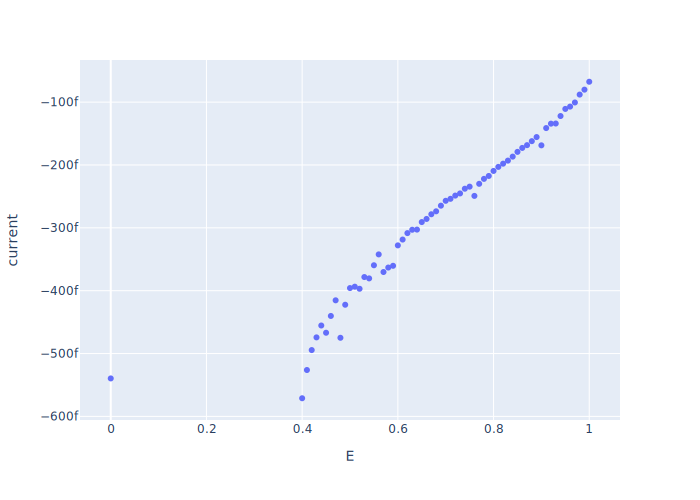

In [8]:
import pandas as pd
import plotly.express as ex

data = pd.read_csv("D:\\EmissionEnergy_Data\\Ampmeter\\09THz_100_40_s1_current_0\\current.csv")

averaged = pd.DataFrame()
averaged["angle"] = data.position.unique()
averaged["E"] = (np.cos(data.position.unique() * np.pi/180))**2
avg = []
for pos in data.position.unique():
    avg.append(data.current.loc[data.position == pos].mean())
averaged["current"] = avg

ex.scatter(averaged, x="angle", y="current")
ex.scatter(averaged, x="E", y="current")

## 2. Power supply - Constant

The setup of the other experients is much like the amperemeter measurement, but with slightly different settings.

Like before, we select a range of positions for the wire grid.

In [1]:
from experiments import *
import numpy as np
positions = [90] + [np.arccos(np.sqrt(E)) * 180 / np.pi for E in np.linspace(0.40,1,61)]

### Initializing the experiment

There are three main differences between using the power supply and the amperemeter.

1. Power supply can be used in tandem with the lucam camera
2. Power supply requires voltage settings
3. Power supply has a fixed integration time, meaning the number of measurements per second is fixed.

Like with the amp meter, the power supply experiment should be initialized. It has the same default stage which can be changed the same way as for the amp meter.

Furthermore, the power supply experiment has the possibility of using the camera. This is enabled by setting cam=True. 

For safety it has "switch_off_after_meas" set to True per default. This shuts the voltage off on the power supply after running a measurement.

Sometimes the ip of the power supply changes. Mostly due to someone moving the ethernet connection to another port. Compensate for this by setting the new ip from the screen in the volt setting.

Note: You need to be connected to the local network (same as power supply) for the connection to be made.

In [2]:
phos = PhosphorCurrent(cam=True, 
                       volt='ws://192.168.1.2:8080',
                       switch_off_after_meas=True,
                       cam_dir="D:\\EmissionEnergy_Data\\PhosCur\\Images")

Waiting for connection to be created ...
Waiting for connection to ws://192.168.1.2:8080 to be ready ...
1 sec : connection status == Configured
Connected to "script_localhost"
Initializing stages
Adjusting stage settings
Homing stages
Homed


In [3]:
phos.stages.move_device(0)

True

### Setting up parameters

The PhosphorCurrent class has a set of default values for all parmeters. However, it is recommended to explicitly set all parameters every run to make sure you know how the experiment is run.


Mandatory:
- volt_per_chan : A list of voltages the same length as used_channels, e.g. [-2000, -1500, 2000]

Others:
- stage_positions : List of positions in degrees (default : [0])
- time_in_position : Number of seconds system will remain in each wire grid position (defualt : 10s)
- directory : A path to the folder in which the experiment folder will be created and data be placed (default : A path which only exist on my pc :-))
- cur_meas_freq : Number of measurements per second (default : 5)
- used_channels : A list of the channels used (default : [1,2,3])
- image_freq : The number of images per second when cam enabled (default : 1 s^-1)
- cam_dir : Directory for saving image files (default: Williams folder on the E-drive)
- switch_off_after_meas : Can be set here or in the initializer, this overwrites the initializer (default : Initialized value)

In [4]:
time_in_position = 40
directory = "D:\\EmissionEnergy_Data\\PhosCur\\Currents"
cur_meas_freq = 5
used_channels = [0,1,2,3]
volt_per_chan = [-2000, -2000, -1500, 2000]
image_freq = 1
switch_off_after_meas = True
cam_dir = "D:\\EmissionEnergy_Data\\PhosCur\\Images"
# positions = [np.arccos(np.sqrt(E)) * 180 / np.pi for E in np.linspace(0.0,1,5)]
stage_positions = positions

phos.set_parameters(time_in_position=time_in_position,
                    directory=directory,
                    stage_positions=stage_positions,
                    cur_meas_freq=cur_meas_freq,
                    used_channels=used_channels,
                    volt_per_chan=volt_per_chan,
                    image_freq=image_freq,
                    switch_off_after_meas=switch_off_after_meas,
                    cam_dir=cam_dir)

{'time_in_position': 40, 'directory': 'D:\\EmissionEnergy_Data\\PhosCur\\Currents', 'stage_positions': [90, 50.76847951640775, 50.184879902738714, 49.60344811067295, 49.02392312365576, 48.44605128967319, 47.869585238633384, 47.29428286789292, 46.719906383757596, 46.146221387977945, 45.5729959991943, 45.0, 44.4270040008057, 43.85377861202206, 43.2800936162424, 42.705717132107075, 42.13041476136661, 41.55394871032681, 40.97607687634424, 40.39655188932704, 39.815120097261286, 39.23152048359225, 38.645483502802286, 38.056729818685504, 37.46496892755558, 36.86989764584401, 36.27119843813895, 35.66853755752876, 35.06156296496058, 34.44990198795349, 33.83315867109736, 33.21091076089908, 32.58270625514922, 31.94805943133005, 31.306446248673048, 30.657298992940547, 30.000000000000004, 29.333874251202875, 28.65818057687103, 27.972101128716048, 27.27472868041229, 26.56505117707799, 25.841932763167126, 25.104090250221375, 24.350063604147067, 23.578178478201817, 22.786497999597145, 21.9727597811544

### Running Experiment

Running the experiment is done by phos.run_experiment. This function takes one mandatory input, the experiment name. The name of the experiment will be the name of the folder in which all the data is placed.

The current when no laser power is applied is almost zero. For the purpose of science, background measurements should be done, but they are not strictly necessary for this device.

The background can be recorded in one of two ways.
1. Using "back_time" keyword when running
2. Doing a measurement of a single position


#### Using back_time

Backtime is used by setting back_time=? after the name of the experiment.
The measurement will use the same settings as the rest of the run, but do a measurement at wire grid angle 90 degrees.
The data from the measurement is placed with the rest of the run and marked as background.

back_time is per default 120s.


In [ ]:
phos.run_experiment("experiment_name", back_time=10)

#### Using seperate experiment

Alternatively, as the wire grid in practive does not dampen the field 100%, one can block the beam and save a seperate measurement.

If this option is used, remmember to set the back_time to 0.

In [6]:
phos.volt.set_channel_voltage(0,-2000)
phos.volt.set_channel_voltage(1,-2000)

'ok'

In [ ]:
phos.set_parameters(stage_positions=[0])
phos.run_experiment("2021_14_02_Powersupply_dark", back_time=0)

In [7]:
phos.set_parameters(stage_positions=positions)
phos.run_experiment("09THz_2000V_90_40_100_s1", back_time=0)

{'stage_positions': [90, 50.76847951640775, 50.184879902738714, 49.60344811067295, 49.02392312365576, 48.44605128967319, 47.869585238633384, 47.29428286789292, 46.719906383757596, 46.146221387977945, 45.5729959991943, 45.0, 44.4270040008057, 43.85377861202206, 43.2800936162424, 42.705717132107075, 42.13041476136661, 41.55394871032681, 40.97607687634424, 40.39655188932704, 39.815120097261286, 39.23152048359225, 38.645483502802286, 38.056729818685504, 37.46496892755558, 36.86989764584401, 36.27119843813895, 35.66853755752876, 35.06156296496058, 34.44990198795349, 33.83315867109736, 33.21091076089908, 32.58270625514922, 31.94805943133005, 31.306446248673048, 30.657298992940547, 30.000000000000004, 29.333874251202875, 28.65818057687103, 27.972101128716048, 27.27472868041229, 26.56505117707799, 25.841932763167126, 25.104090250221375, 24.350063604147067, 23.578178478201817, 22.786497999597145, 21.972759781154405, 21.134292214786225, 20.267901055658275, 19.36971229892783, 18.434948822922017, 

## 3. Power supply - Variable

Power supply variable is much like the constant one, but with a few additional settings allowing you to vary the voltage of a channel while changing the grid positions.

Like before, we select a range of positions for the wire grid.

Additionally, we define a set of voltages we want a channel to go through.

In [ ]:
from experiments import *
import numpy as np
# positions = [np.arccos(np.sqrt(E)) * 180 / np.pi for E in np.linspace(0.75,1,6)]
# positions = [np.arccos(np.sqrt(0.85)) * 180 / np.pi]
positions = [0]
voltages = np.linspace(-1485,-1525,41)
print(voltages)

### Initializing the experiment

The initialization of this experiment is much like the other power supply experiment with camera settings and ip settings. 

In [9]:
emission = EmissionEnergy(cam=True, 
                          volt='ws://192.168.1.2:8080',
                          switch_off_after_meas=True,
                          cam_dir="D:\\EmissionEnergy_Data\\Images")

Waiting for connection to be created ...
Waiting for connection to ws://192.168.1.2:8080 to be ready ...
1 sec : connection status == Configured
Connected to "script_localhost"
Initializing stages
Adjusting stage settings
Homing stages
Homed


### Setting up parameters

The EmissionEnergy class has a set of default values for all parmeters. However, it is recommended to explicitly set all parameters every run to make sure you know how the experiment is run.


Mandatory:
- volt_per_chan : A list of voltages the same length as used_channels, e.g. [-2000, -1500, 2000]

Others:
- channel_voltages : List of voltages for variable channel (default : [-1500])
- stage_positions : List of positions in degrees (default : [0])
- time_in_position : Number of seconds system will remain in each wire grid position (defualt : 10s)
- directory : A path to the folder in which the experiment folder will be created and data be placed (default : A path which only exist on my pc :-))
- cur_meas_freq : Number of measurements per second (default : 5)
- used_channels : A list of the channels used (default : [1,2,3])
- image_freq : The number of images per second when cam enabled (default : 1 s^-1)
- cam_dir : Directory for saving image files (default: Williams folder on the E-drive)
- switch_off_after_meas : Can be set here or in the initializer, this overwrites the initializer (default : Initialized value)

In [ ]:
time_in_position = 20
directory = "D:\\EmissionEnergy_Data\\EmissionEnergy"
stage_positions = positions
cur_meas_freq = 5
used_channels = [0,1,2,3]
volt_per_chan = [-1500, -1500, -1500, 2000]
image_freq = 1
switch_off_after_meas = True
cam_dir = "D:\\EmissionEnergy_Data\\Images"

emission.set_parameters(channel_voltages=voltages,
                        time_in_position=time_in_position,
                        directory=directory,
                        stage_positions=stage_positions,
                        cur_meas_freq=cur_meas_freq,
                        used_channels=used_channels,
                        volt_per_chan=volt_per_chan,
                        image_freq=image_freq,
                        switch_off_after_meas=switch_off_after_meas,
                        cam_dir=cam_dir)

### Running Experiment

Running the experiment is done by emission.run_experiment. This function takes one mandatory input, the experiment name. The name of the experiment will be the name of the folder in which all the data is placed.

When running an emission energy experiment, you need to set the channel which should be varied, else it uses the first used channel per default, i.e. channel 1 of channels [1,2,3] or channel 3 of [3,0,4].

The current when no laser power is applied is almost zero. For the purpose of science, background measurements should be done, but they are not strictly necessary for this device.

The background can be recorded in one of two ways.
1. Using "back_time" keyword when running
2. Doing a measurement of a single position


#### Using back_time

Backtime is used by setting back_time=? after the name of the experiment.
The measurement will use the same settings as the rest of the run, but do a measurement at wire grid angle 90 degrees.
The data from the measurement is placed with the rest of the run and marked as background.

back_time is per default 120s.


In [ ]:
emission.run_experiment("experiment_name", back_time=10, variable_channel=0)

#### Using seperate experiment

Alternatively, as the wire grid in practive does not dampen the field 100%, one can block the beam and save a seperate measurement.

If this option is used, remmember to set the back_time to 0.

In [ ]:
emission.set_parameters(stage_positions=[90])
emission.run_experiment("09THz_testrun_dark_3", back_time=0, variable_channel=[0,1])

In [ ]:
emission.set_parameters(stage_positions=positions)
emission.run_experiment("08THz_A_100_s0_U_1485_to_1725_s1", back_time=0, variable_channel=[0,1])

In [ ]:
positions

In [ ]:
cam.connected

In [ ]:
import machines
cam = machines.Camera()

In [ ]:
from PIL import Image
emission.cam = emission.get_camera()
Image.fromarray(emission.cam.TakeSnapshot())

In [ ]:
from PIL import Image

emission.cam.snapshot.exposure = 100

emission.stages.move_device(90)
# emission.volt.set_channel_voltage(0,-2000)
# emission.volt.set_channel_voltage(1,-2000)

shot1 = emission.cam.TakeSnapshot()/10
for i in range(9):
    try:
        shot1 += emission.cam.TakeSnapshot()/10
    except Exception as e:
        error = e
print(shot1)
        
# emission.volt.set_channel_voltage(0,-1000)
# emission.volt.set_channel_voltage(1,-1000)

# time.sleep(10)
shot2 = emission.cam.TakeSnapshot() / 10
for i in range(9):
    try:
        shot2 += emission.cam.TakeSnapshot()/10
    except Exception as e:
        error = e
print(shot2)

In [ ]:
emission.cam = emission.get_camera()
emission.cam.snapshot.exposure = 100
shot2 = emission.cam.TakeSnapshot()

In [ ]:
plt.imshow(shot1 - shot2)

In [ ]:
%matplotlib notebook
%matplotlib inline
%pylab inline
import matplotlib
matplotlib.use('TkAgg')
from experiments import *
cm = CurrentMonitor(volt='ws://192.168.1.2:8080')

In [ ]:
cm.start()

In [ ]:
cm.current

In [ ]:
from lucam import API, Lucam

In [ ]:
snapshot = API.LUCAM_SNAPSHOT()
camera = Lucam()

In [ ]:
snapshot.format = camera.GetFormat()[0]
snapshot.exposure = 500
snapshot.gain = 1
snapshot.timeout = 1000.0
snapshot.gainRed = 1.0
snapshot.gainBlue = 1.0
snapshot.gainGrn1 = 1.0
snapshot.gainGrn2 = 1.0
snapshot.useStrobe = False
snapshot.strobeDelay = 0.0
snapshot.useHwTrigger = 0
snapshot.shutterType = 0
snapshot.exposureDelay = 0.0
snapshot.bufferlastframe = 0


In [ ]:
snapshot

In [ ]:
camera.TakeSnapshot()

In [ ]:
error == lucam.lucam.LucamError(emission.cam.camera)

In [ ]:
import lucam

In [ ]:
from lucam import Lucam

In [ ]:
lucam.lucam.LucamError

In [ ]:
lucam.lucam.LucamError(6)

In [ ]:
emission.stages.move_device(40)

In [ ]:
np.cos(40*np.pi/180)**2

In [ ]:
!pip show lucam

In [ ]:
import pandas as pd
exposure_frame = pd.DataFrame(columns=["angle","exposure"])
exposure_frame = exposure_frame.append(pd.DataFrame([[10,40]],columns=["angle","exposure"]), ignore_index=True)
exposure_frame.to_csv("D:\\test_file.csv", index=False)
print(exposure_frame)

In [ ]:
emission.camera.snapshot.exposure

In [5]:
emission.volt.set_channel_voltage(0,-2000)
emission.volt.set_channel_voltage(1,-2000)

NameError: name 'emission' is not defined

155


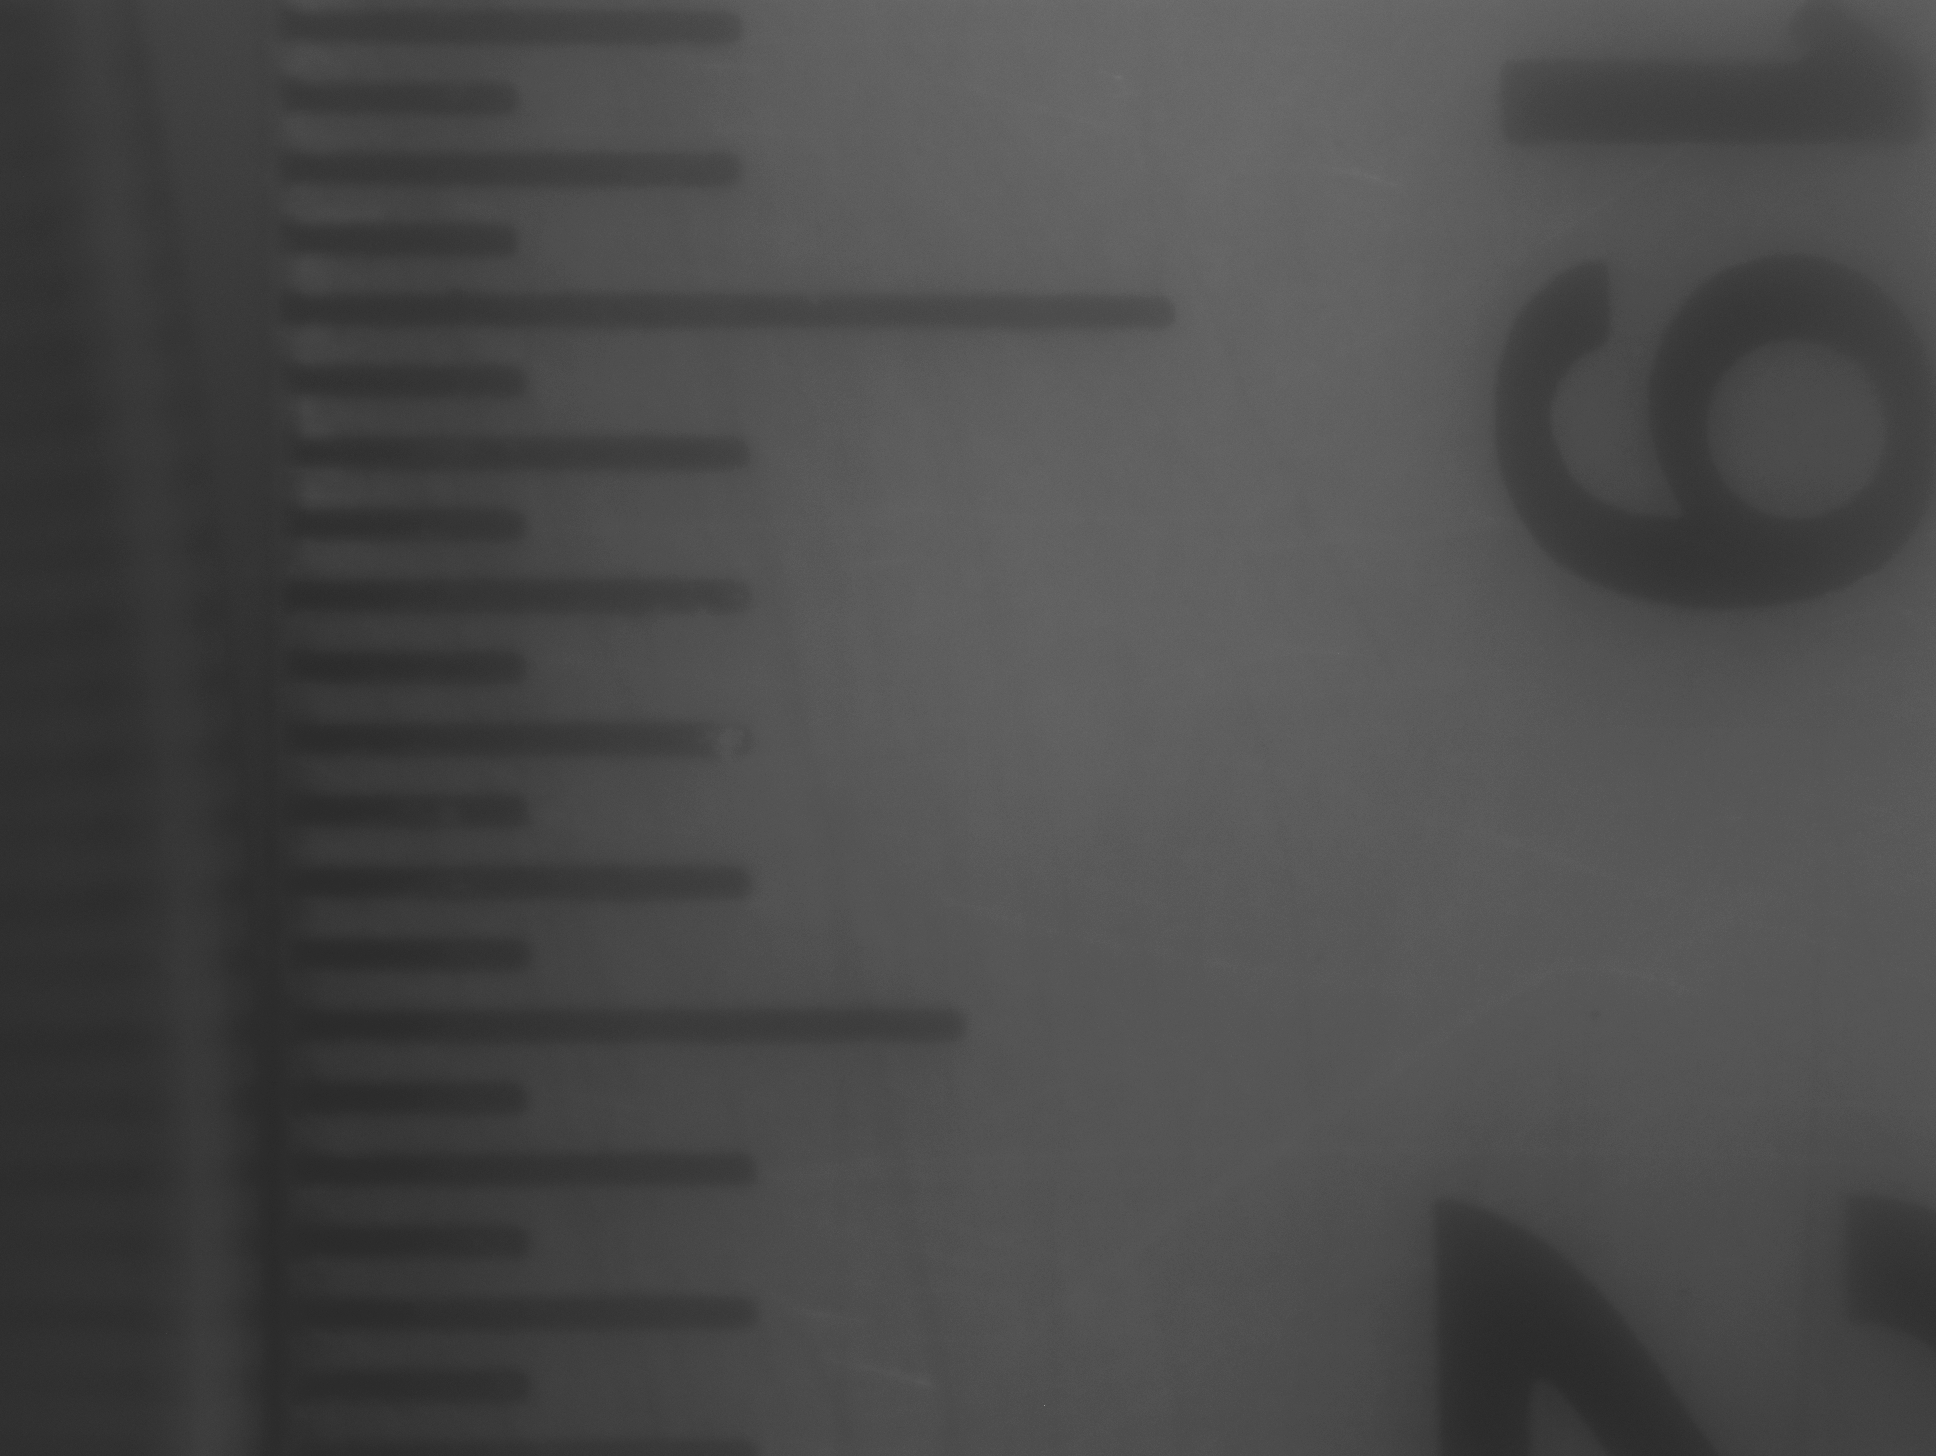

In [12]:
emission.cam.snapshot.exposure = 100
shot = emission.cam.TakeSnapshot()
from PIL import Image
print(np.max(shot))
image = Image.fromarray(shot)
image

In [ ]:
emission.stages.move_device(0)

In [ ]:
image

In [13]:
image.save("D:\\EmissionEnergy_Data\\ruler.png")

## 4. Finding threshold for extraction voltage

The purpose of this experiement is to be able, visually and nuerically, to identify the highest negative extraction voltage, with which electrons reach the MCP.

### Imports

In [1]:
# Import the experiments package
%matplotlib notebook
from experiments import *
import numpy as np

### Connections

In [2]:
threshold = ExtractionThreshold(cam=True, 
                          volt='ws://192.168.1.2:8080',
                          switch_off_after_meas=True,
                          cam_dir="D:\\EmissionEnergy_Data\\ThressholdExtraction")

Waiting for connection to be created ...
Waiting for connection to ws://192.168.1.2:8080 to be ready ...
1 sec : connection status == Configured
Connected to "script_localhost"
Initializing stages
Adjusting stage settings
Homing stages
Homed


### Settings

Settings are set the same way as for emission energy.

In [3]:
time_in_position = 10
directory = "D:\\EmissionEnergy_Data\\ThressholdExtraction\\currents"
cur_meas_freq = 5
used_channels = [0,1,2,3]
volt_per_chan = [-1500, -1500, -1500, 2000]
image_freq = 1
switch_off_after_meas = True
cam_dir = "D:\\EmissionEnergy_Data\\ThressholdExtraction\\images"

stage_positions = [0]
voltages = [-1490 + 2*i for i in range(61)]
# voltages = [-1428 + 2*i for i in range(20)]
# voltages = [-1476]

threshold.set_parameters(channel_voltages=voltages,
                        time_in_position=time_in_position,
                        directory=directory,
                        stage_positions=stage_positions,
                        cur_meas_freq=cur_meas_freq,
                        used_channels=used_channels,
                        volt_per_chan=volt_per_chan,
                        image_freq=image_freq,
                        switch_off_after_meas=switch_off_after_meas,
                        cam_dir=cam_dir)

{'channel_voltages': [-1490, -1488, -1486, -1484, -1482, -1480, -1478, -1476, -1474, -1472, -1470, -1468, -1466, -1464, -1462, -1460, -1458, -1456, -1454, -1452, -1450, -1448, -1446, -1444, -1442, -1440, -1438, -1436, -1434, -1432, -1430, -1428, -1426, -1424, -1422, -1420, -1418, -1416, -1414, -1412, -1410, -1408, -1406, -1404, -1402, -1400, -1398, -1396, -1394, -1392, -1390, -1388, -1386, -1384, -1382, -1380, -1378, -1376, -1374, -1372, -1370], 'time_in_position': 10, 'directory': 'D:\\EmissionEnergy_Data\\ThressholdExtraction\\currents', 'stage_positions': [0], 'cur_meas_freq': 5, 'used_channels': [0, 1, 2, 3], 'volt_per_chan': [-1500, -1500, -1500, 2000], 'image_freq': 1, 'switch_off_after_meas': True, 'cam_dir': 'D:\\EmissionEnergy_Data\\ThressholdExtraction\\images'} 



### Running Experiment

In [4]:
threshold.run_experiment("07THz_A_0_V_1490_1370_s2", variable_channel=[0,1], start_exposure=200, filternum=3)

Ramping up voltage
Waiting for ramp to be complete
Making sure stages are homed
Homed
Done ramping
Position 1 out of 1
Voltage : -1490, 1 out of 61
Position : 0, 1 out of 1
Getting right exposure
187 200.0
255 280
Final Exposure :  280
Starting Camera thread
Starting Volt/Current thread
Voltage:  -1490  is done

Starting Camera thread
Starting Volt/Current thread
Voltage:  -1490  is done

Voltage : -1488, 2 out of 61
Position : 0, 1 out of 1
Getting right exposure
168 200.0
243 280
Final Exposure :  280
Starting Camera thread
Starting Volt/Current thread
Voltage:  -1488  is done

Starting Camera thread
Starting Volt/Current thread
Voltage:  -1488  is done

Voltage : -1486, 3 out of 61
Position : 0, 1 out of 1
Getting right exposure
162 200.0
241 300
Final Exposure :  300
Starting Camera thread
Starting Volt/Current thread
Voltage:  -1486  is done

Starting Camera thread
Starting Volt/Current thread
Voltage:  -1486  is done

Voltage : -1484, 4 out of 61
Position : 0, 1 out of 1
Getting 

In [15]:
threshold.volt.set_channel_voltage(0,-1500)
threshold.volt.set_channel_voltage(1,-1500)

'ok'

In [6]:
threshold.cam.snapshot.exposure

40.0

69


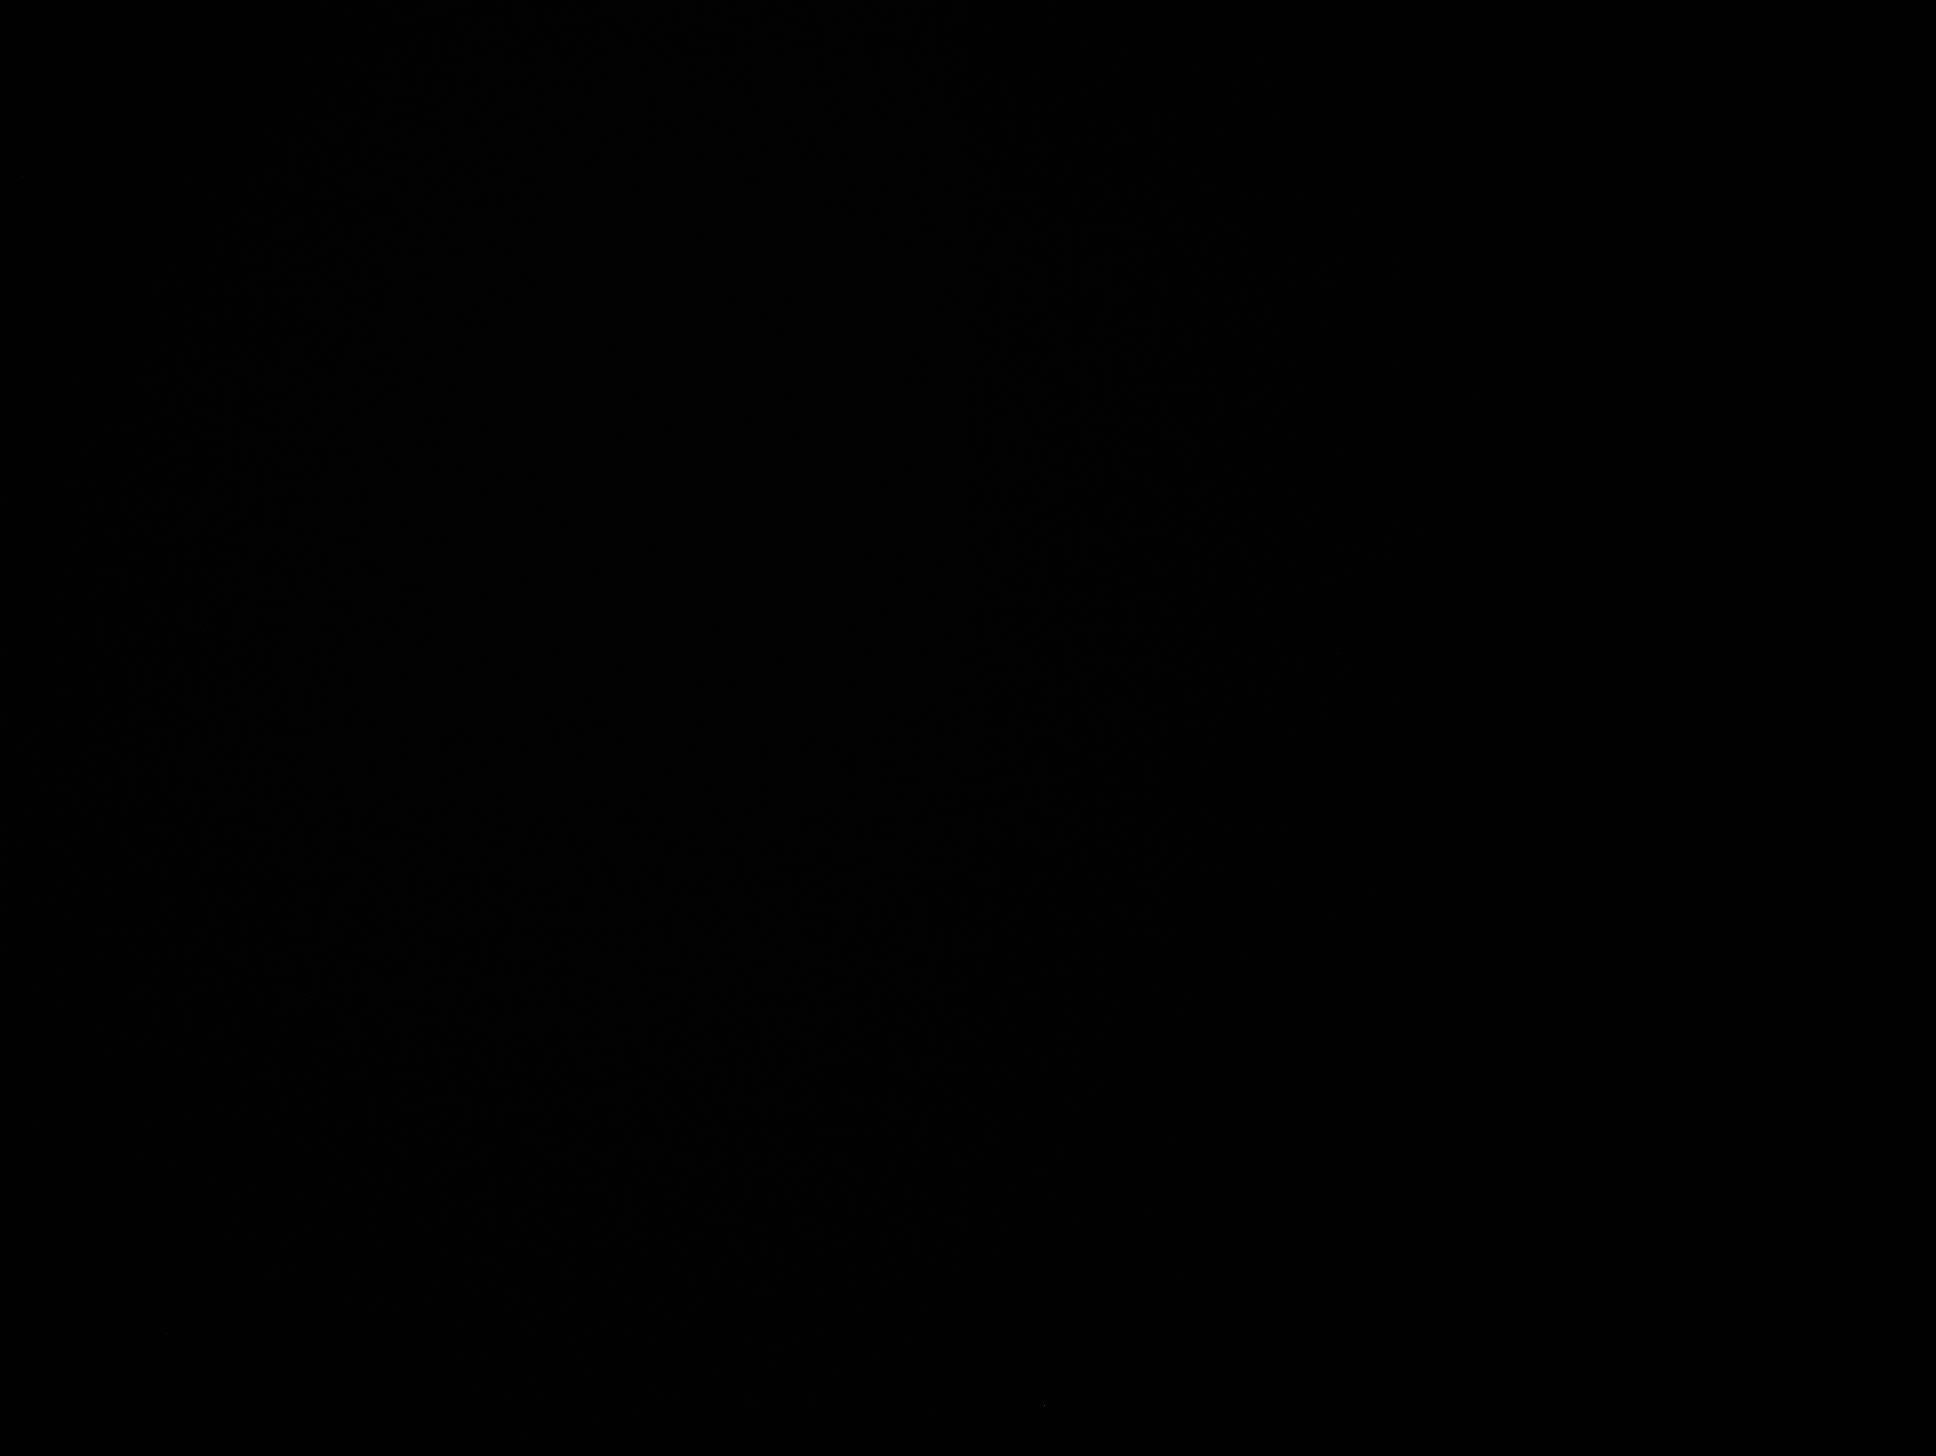

In [15]:
from PIL import Image

threshold.cam.create_snapshot(exposure=100)
shot = threshold.cam.TakeSnapshot()
# maxpos = np.where(shot == np.max(shot))
# shot[maxpos[0][0],maxpos[1][0]] = 0
# maxpos = np.where(shot == np.max(shot))
# shot[maxpos[0][0],maxpos[1][0]] = 0
# maxpos = np.where(shot == np.max(shot))
# shot[maxpos[0][0],maxpos[1][0]] = 0
# maxpos = np.where(shot == np.max(shot))
# shot[maxpos[0][0],maxpos[1][0]] = 0
# maxpos = np.where(shot == np.max(shot))
# shot[maxpos[0][0],maxpos[1][0]] = 0
# maxpos = np.where(shot == np.max(shot))
# shot[maxpos[0][0],maxpos[1][0]] = 0
print(np.max(shot))
im = Image.fromarray(shot)
# threshold.cam.SaveImage(shot, "D:\\EmissionEnergy_Data\\ThressholdExtraction\\images\\08THz_A_0_V_1490_1430_s2_3\\blocked.png")
im

In [5]:
threshold.stages.move_device(0)

True

In [61]:
print(2721124 % (1456-1))
print(2721124 % 1936)
# shot.shape

274
1044


In [20]:
threshold.cam.create_snapshot(exposure=500)

In [10]:
threshold.get_max_exposure(exposure_time=20)

13 20.0
241 450


450

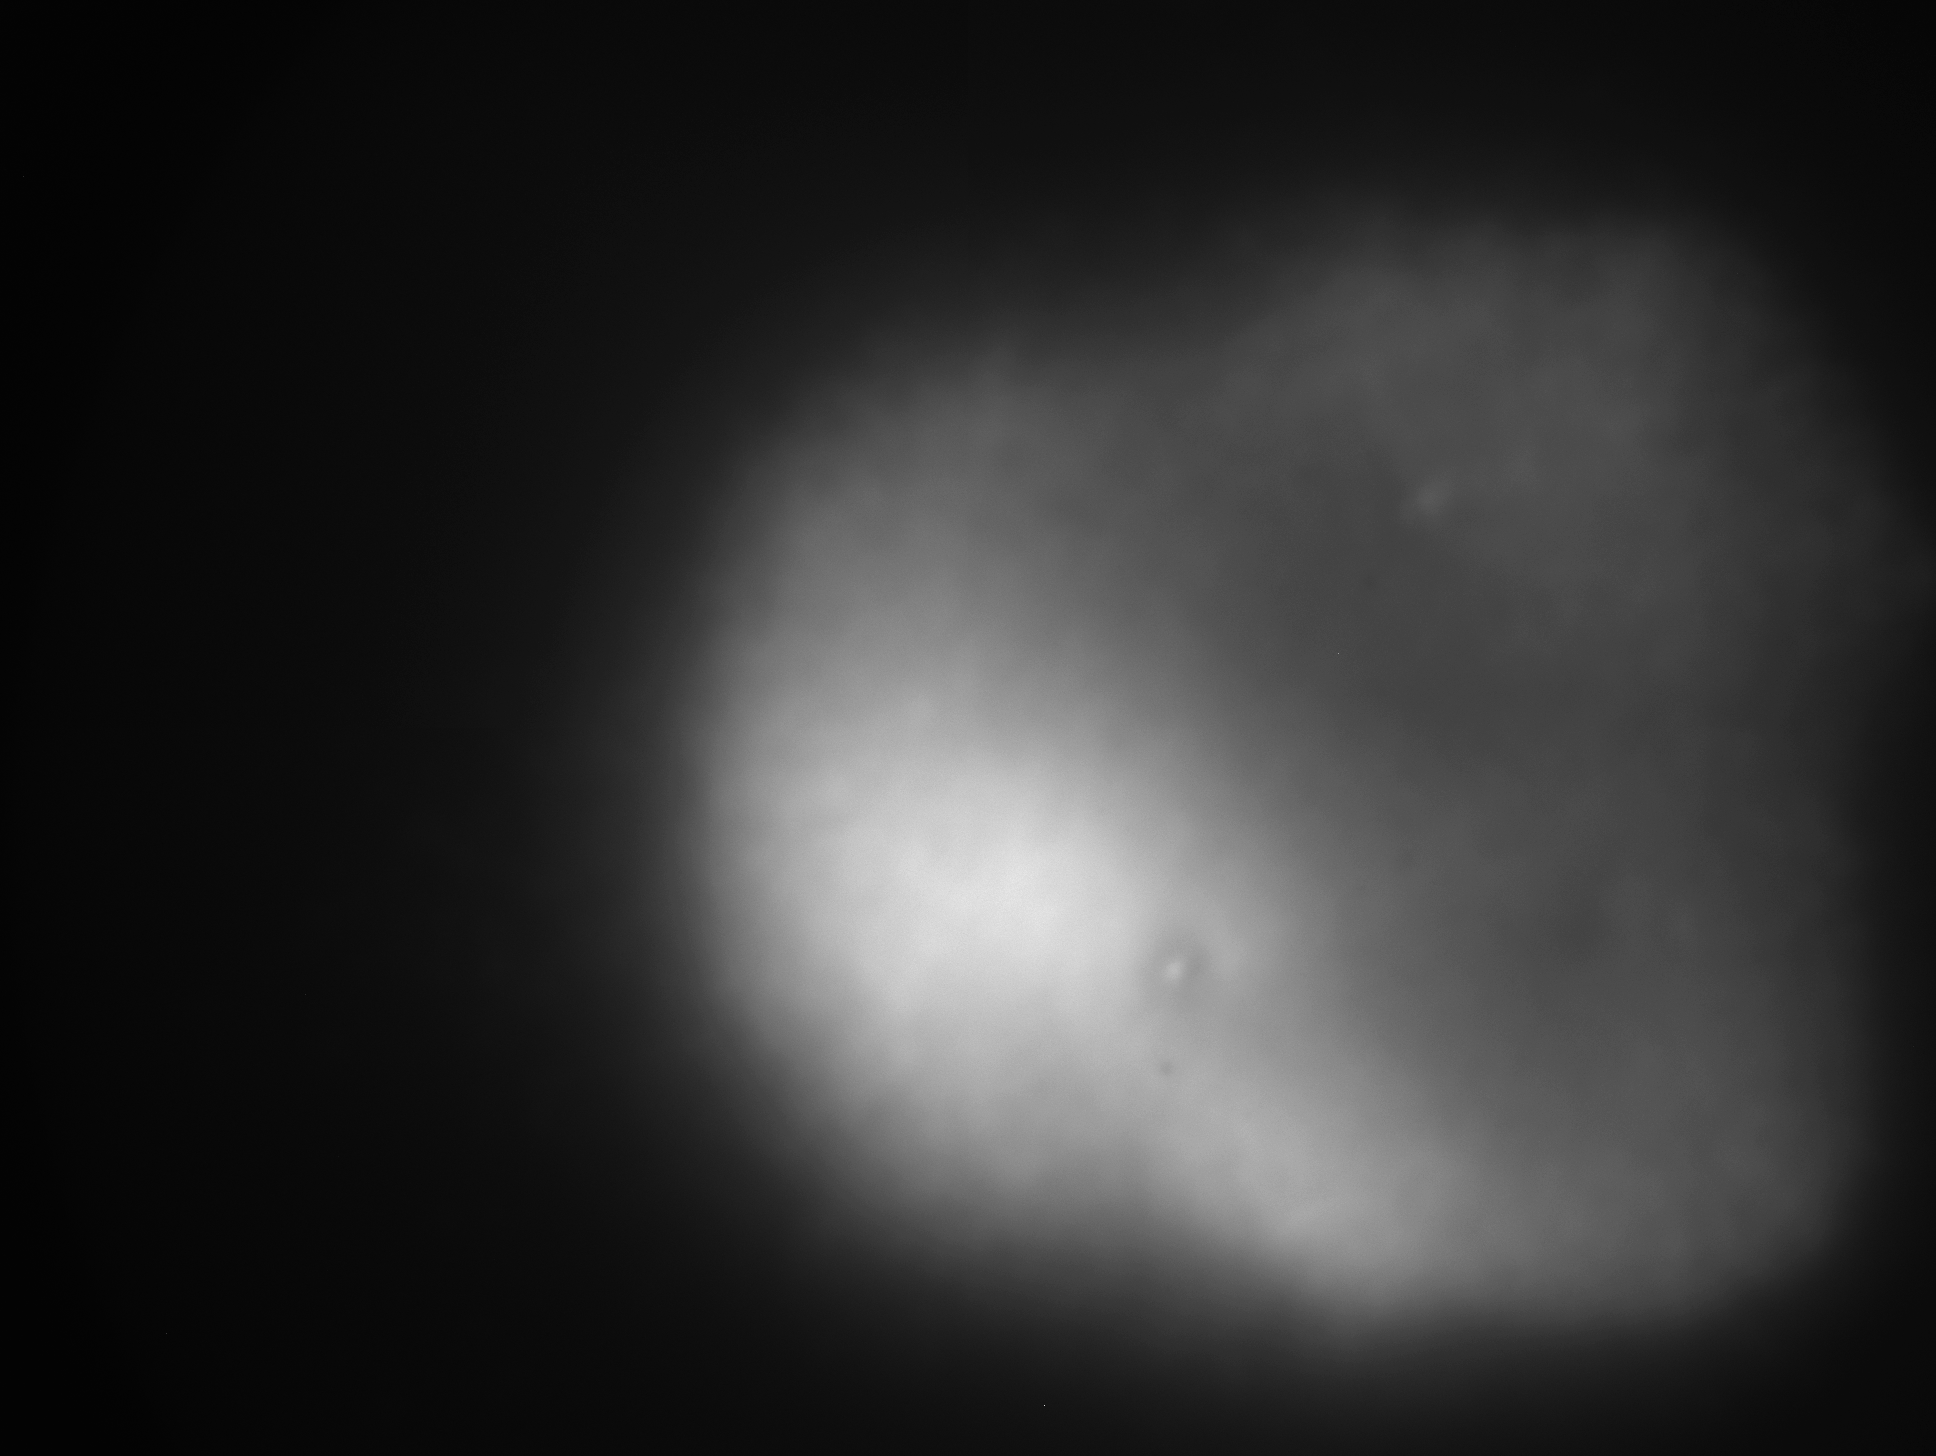

In [13]:
im

## 5. Current Monitor

In [1]:
from experiments import *
import numpy as np
positions = [0]

### Initialize experiment

In [5]:
CurrMon = CurrentMonitor(volt='ws://192.168.1.2:8080')

Waiting for connection to be created ...
Waiting for connection to ws://192.168.1.2:8080 to be ready ...
Connected to "script_localhost"
{'used_channels': [1, 2, 3], 'volt_per_chan': [-2000, -1500, 2000], 'directory': 'DontNeedOne'} 



### Setting Parameters

In [12]:
used_channels=[0,1,2,3]
volt_per_chan=[-2000,-2000,-1500,2000]
CurrMon.set_parameters(used_channels=used_channels,
                       volt_per_chan=volt_per_chan)

{'used_channels': [0, 1, 2, 3], 'volt_per_chan': [-2000, -2000, -1500, 2000]} 



### Run Experiment

In [ ]:
%matplotlib notebook
%matplotlib inline
%pylab inline
import matplotlib
matplotlib.use('TkAgg')
CurrMon.start()

In [1]:
%matplotlib notebook
%matplotlib inline
%pylab inline
import matplotlib
matplotlib.use('TkAgg')
from experiments import *
cm = CurrentMonitor(volt='ws://192.168.1.2:8080')

Populating the interactive namespace from numpy and matplotlib
Waiting for connection to be created ...
Waiting for connection to ws://192.168.1.2:8080 to be ready ...
1 sec : connection status == Configured
Connected to "script_localhost"
{'used_channels': [1, 2, 3], 'volt_per_chan': [-2000, -1500, 2000], 'directory': 'DontNeedOne'} 



In [ ]:
cm.start()

Ramping up voltage
Waiting for ramp to be complete
